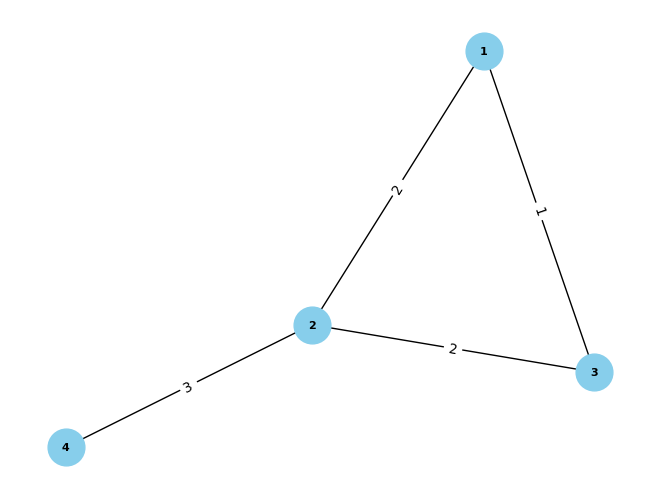

In [65]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random

# Create a graph with 10 nodes
G = nx.Graph()

# Add nodes to the graph
nodes = 4

G.add_nodes_from(range(1, nodes))
G.add_edge(1, 2, weight=2)
G.add_edge(1, 3, weight=1)
G.add_edge(3, 2, weight=2)
G.add_edge(2, 4, weight=3)

# Plot the graph with weights
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, font_weight='bold', node_size=700, node_color='skyblue', font_size=8)

# Add edge labels with weights
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

plt.show()

## 1. Weight matrix

In [95]:
weight_array = nx.adjacency_matrix(G, weight='weight').todense()
print(weight_array)

[[0 2 1 0]
 [2 0 2 3]
 [1 2 0 0]
 [0 3 0 0]]


In [96]:
start_node = 3
shortest_paths = nx.shortest_path_length(G, source=start_node, weight='weight')
print(f"Shortest distances from node {start_node}: {shortest_paths}")

Shortest distances from node 3: {3: 0, 1: 1, 2: 2, 4: 5}


In [97]:
shortest_paths

{3: 0, 1: 1, 2: 2, 4: 5}

In [98]:
np.random.seed(41)
nod_numbers = len(G.nodes())

probabilities = np.round(np.random.rand(nod_numbers, nod_numbers), decimals=2)
prob_array = np.where(weight_array > 0, probabilities, 0)
print(prob_array)

[[0.   0.05 0.68 0.  ]
 [0.12 0.   0.19 0.67]
 [0.92 0.42 0.   0.  ]
 [0.   0.32 0.   0.  ]]


In [99]:
def infection_matrix(net):
    
    num_nodes = len(net.nodes())
    infection_array = np.zeros((num_nodes, num_nodes), dtype=float)

                
    return infection_array

infect_array = infection_matrix(G)
print(infect_array)

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


In [100]:
node_idx = (np.array(list(shortest_paths.keys())) - 1)[-3:]
node_idx

array([0, 1, 3])

In [101]:
def update_time(times_matrix, seed_node):
    
    values = 0
    track = np.array([seed_node - 1])
    
    for _ in range(times_matrix.shape[0]):
        try:
            # What was the min value of the arrange greater than 0 (it-self)--> faster transmittion
            min_value = np.min(times_matrix[(seed_node - 1), times_matrix[(seed_node - 1), :] > values])
            print("min_values", min_value)
            values = min_value

            # Index
            # find the array of indeces in the array with minimum values Nodes
            Nodes = np.where(times_matrix[(seed_node - 1), :] == min_value)[0]

            ##########################
            #Update the infection time
            ##########################
            update = times_matrix[Nodes, :] 
            update[update > 0] += min_value
            #add the update
            times_matrix[Nodes, :] = update
            
            track = np.append(track, [Nodes])
            
        except:
            break
            
    return times_matrix, track    

In [75]:
#time_array, track = update_time(weight_array, seed_node = 3)

In [102]:
print(weight_array)

[[0 2 1 0]
 [2 0 2 3]
 [1 2 0 0]
 [0 3 0 0]]


In [103]:
time_array2, track = update_time(weight_array, seed_node = 3)

min_values 1
min_values 2


In [104]:
time_array2

array([[0, 3, 2, 0],
       [4, 0, 4, 5],
       [1, 2, 0, 0],
       [0, 3, 0, 0]])

In [105]:
infect_array

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [140]:
prob_array

array([[0.  , 0.05, 0.68, 0.  ],
       [0.12, 0.  , 0.19, 0.67],
       [0.92, 0.42, 0.  , 0.  ],
       [0.  , 0.32, 0.  , 0.  ]])

In [107]:
track # NODES

array([2, 0, 1])

In [144]:
p = 0.03
print("nod", track[0])
infection_row = np.where(prob_array[track[0], :] >= p, 1, 0)
infect_array[track[0],:] = infection_row
print(prob_array[track[0], :])
print(infect_array[track[0], :])
print("GO inside")


for i in infection_row[1:]: # 1, 0, 0, 0
    print("i", i)
    
    if i == 1:
        for j in track[1:]: #Nodes 0 and 1 left
            print(j)
            infect_row = np.where(prob_array[j, :] >= p, 1, 0)
            infect_array[j,:] = infect_row
            print("infected row", infect_row)
            print(prob_array[j, :])
            print("done")
    else:
        print("i =", i, "pass")
        pass
     

nod 2
[0.92 0.42 0.   0.  ]
[1. 1. 0. 0.]
GO inside
i 1
0
infected row [0 1 1 0]
[0.   0.05 0.68 0.  ]
done
1
infected row [1 0 1 1]
[0.12 0.   0.19 0.67]
done
i 0
i = 0 pass
i 0
i = 0 pass


In [145]:
prob_array

array([[0.  , 0.05, 0.68, 0.  ],
       [0.12, 0.  , 0.19, 0.67],
       [0.92, 0.42, 0.  , 0.  ],
       [0.  , 0.32, 0.  , 0.  ]])

In [146]:
infect_array

array([[0., 1., 1., 0.],
       [1., 0., 1., 1.],
       [1., 1., 0., 0.],
       [0., 0., 0., 0.]])

In [128]:
track

array([2, 0, 1])